# Longitudinal Contours

Versions:  
v1: Used for initial polar export of cell 4  
v2: Explore other cells, adjust export formatting  


Load cell 4 and create longitudinal contours. Output special set of contours which radiate interpolations consistently / concentrically form a single point. 

In [1]:
import importlib
import confocal
importlib.reload(confocal)

import glob, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import imageio
import re
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.measurements import center_of_mass
from scipy.interpolate import interp2d,RegularGridInterpolator
from random import random
from tqdm import tqdm
from scipy.interpolate import interp1d

from itertools import accumulate
from skimage.measure import find_contours
from scipy.spatial import ConvexHull
import time

import itertools

52
Intensity_Z000 (2048, 2048, 3)
Intensity_Z001 (2048, 2048, 3)
Intensity_Z002 (2048, 2048, 3)
Intensity_Z003 (2048, 2048, 3)
Intensity_Z004 (2048, 2048, 3)
Intensity_Z005 (2048, 2048, 3)
Intensity_Z006 (2048, 2048, 3)
Intensity_Z007 (2048, 2048, 3)
Intensity_Z008 (2048, 2048, 3)
Intensity_Z009 (2048, 2048, 3)
Intensity_Z010 (2048, 2048, 3)
Intensity_Z011 (2048, 2048, 3)
Intensity_Z012 (2048, 2048, 3)
Intensity_Z013 (2048, 2048, 3)
Intensity_Z014 (2048, 2048, 3)
Intensity_Z015 (2048, 2048, 3)
Intensity_Z016 (2048, 2048, 3)
Intensity_Z017 (2048, 2048, 3)
Intensity_Z018 (2048, 2048, 3)
Intensity_Z019 (2048, 2048, 3)
Intensity_Z020 (2048, 2048, 3)
Intensity_Z021 (2048, 2048, 3)
Intensity_Z022 (2048, 2048, 3)
Intensity_Z023 (2048, 2048, 3)
Intensity_Z024 (2048, 2048, 3)
Intensity_Z025 (2048, 2048, 3)
Intensity_Z026 (2048, 2048, 3)
Intensity_Z027 (2048, 2048, 3)
Intensity_Z028 (2048, 2048, 3)
Intensity_Z029 (2048, 2048, 3)
Intensity_Z030 (2048, 2048, 3)
Intensity_Z031 (2048, 2048, 3)
Inten

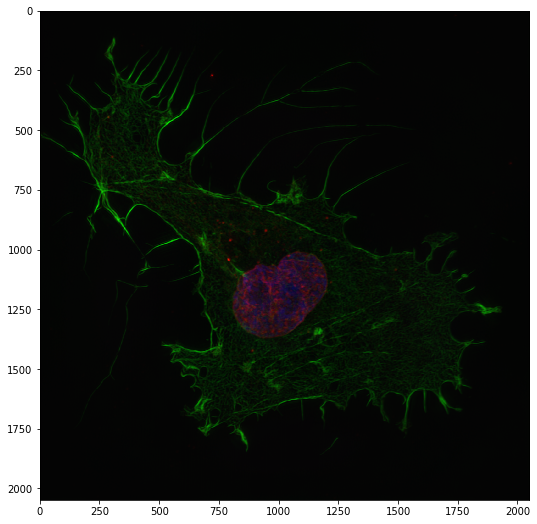

Cell 4


In [5]:
cell_num = 4
_ = cell_num

base_dir = 'datasets/SR_HUVEC1/'
specific_ds = 'HUVEC Cell %d/' % _
target_dir = os.path.join(base_dir, specific_ds, 'Intensity.png.export/')
source_folder = os.path.join(base_dir, specific_ds)

# os.mkdir(source_)

#     print('isfile', os.path.isfile(os.path.join(source_folder,'HUVEC Cell 1.ome.tif')))
if True:
    confocal.export_sr_ome(target_dir, source_folder, 'HUVEC Cell %d.ome.tif' % _, n_channels=4, keep3=[0,2,3]) # 0, 1, 3
    # 1: 0 2 3
    # 2: 0 2 3 

globular_full = os.path.join(base_dir, specific_ds,
                             'Intensity.png.export/Intensity*.png')  # 'AFM Test 100x/AFM Oversampling - Deconvolution/Intensity.png.export/*.png'
print(len(glob.glob(globular_full)))
destdir = os.path.join(base_dir, specific_ds)
os.makedirs(os.path.join(destdir, 'objects'), exist_ok=True)
desc = 'srh1_%d' % _
if True:
    confocal.max_projection(globular_full, do_plot=True, do_save=True, destdir=destdir,
                            filedesc=desc, as_colors=[0, 1, 2])
    print('Cell %d' % _)
plt.show()    

Case: SRH1_4
Raw png count: datasets/SR_HUVEC1/HUVEC Cell 4/Intensity.png.export/Intensity_Z*.png 44
Full images n: 44
cwd: /Users/asears/work/confocal
Found 44 files, ie: datasets/SR_HUVEC1/HUVEC Cell 4/Intensity.png.export/Intensity_Z038.png
Results: 44 files w/ indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
cwd: /Users/asears/work/confocal
Found 1 files, ie: datasets/SR_HUVEC1/HUVEC Cell 4/objects/Nucleus_1.png
Results: 1 files w/ indices: [1]
cwd: /Users/asears/work/confocal
Found 1 files, ie: datasets/SR_HUVEC1/HUVEC Cell 4/objects/Cytoplasm_1.png
Results: 1 files w/ indices: [1]


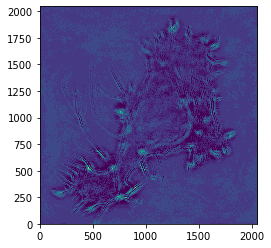

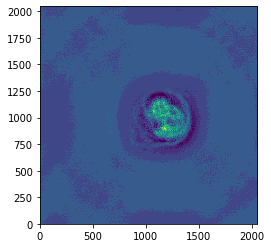

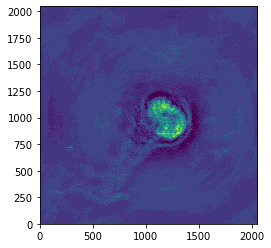

finished cropping
finished four_panel


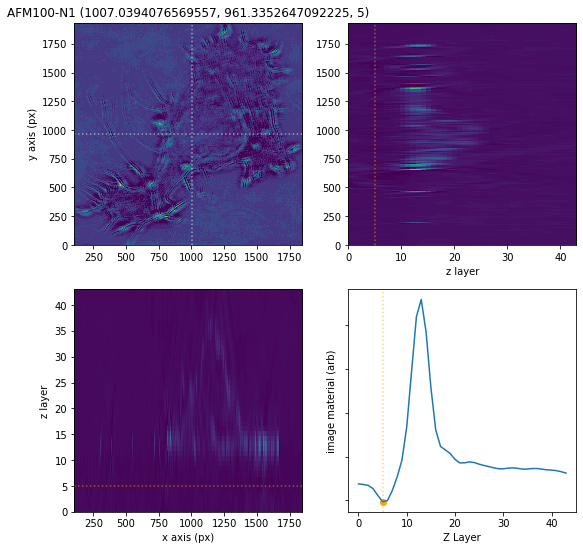

In [7]:
celln = 4
case = 'SRH1_%d' % celln

example_z = 15
print('Case:', case)

base_folder = 'datasets/SR_HUVEC1/HUVEC Cell %d/' % celln

objects_folder_base = base_folder # 'dataset/20200724 AFM Test 3/HUVEC Cyto(g) Nucleus(b).export'
#     objects_folder_base = 'datasets/HUVEC 3D Reconstruction Files/HUVEC Tubulin AD 0.7 ZStack Decon cellSens.export/'

globular_full = os.path.join(base_folder, 'Intensity.png.export/Intensity_Z*.png') #'AFM Test 100x/AFM Oversampling - Deconvolution/Intensity.png.export/*.png'
print('Raw png count:', globular_full, len(glob.glob(globular_full)))
destdir = base_folder
desc = 'srh1_%d' % celln
# 'index_re': r'_Z(\d+)',
o = dict(
    globular_full=globular_full,
    # reuse segmentation
    globular_nucleus = os.path.join(objects_folder_base,'objects/Nucleus*.png'),
    globular_cyto = os.path.join(objects_folder_base,'objects/Cytoplasm*.png'),
    source_folder = base_folder, # diagnostics folder will be created here

    nuc_color=0, # 2 0 2
    cyto_color=1,
    other_color=2,    
)

cs1 = confocal.gen_load(o)

example_z=5
res = cs1.render_image('cyto_linear3D',sliced=example_z, series=False, do_plot=True)
plt.show()
res = cs1.render_image('other_linear3D',sliced=example_z, series=False, do_plot=True)
plt.show()
res = cs1.render_image('nucleus_linear3D',sliced=example_z, series=False, do_plot=True)
plt.show()

cyto_id = 1
cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test', debug=False, series=False, window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent'])
cs1.create_cropped('nucleus_linear3D', cropped_name='nucleus_test', debug=False, series=False, window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent'])
cs1.create_cropped('other_linear3D', cropped_name='other_test', debug=False, series=False, window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent'])
print('finished cropping')
if True:
    cs1.four_panel('cyto_test',desc='AFM100-N1', center_on='nucleus_test', z=example_z,upscale=1) # upscale=1.0, z=13,
    print('finished four_panel')
    plt.show()
#     cs1.four_panel('cyto_test',desc='AFM100-N1')

if False:
    confocal.export_set_for_annotation(cs1,'cyto_linear3D', use_log=False, do_show=False)
    confocal.export_set_for_annotation(cs1,'other_linear3D', use_log=False, do_show=False)
    confocal.export_set_for_annotation(cs1,'nucleus_linear3D', use_log=False, do_show=False)
#         break



In [119]:
import contour
import confocal
import contour
from copy import deepcopy
import os
import matplotlib.pyplot as plt
import numpy as np

In [120]:
from importlib import reload
reload(contour)

<module 'contour' from '/Users/asears/work/confocal/contour.py'>

100%|██████████| 25/25 [00:00<00:00, 1588.29it/s]
0it [00:00, ?it/s]

Starting to export 4
tips:  [array([1122, 1367], dtype=object), array([1005, 1190], dtype=object)]
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using given cXY: (620, 600)
Using

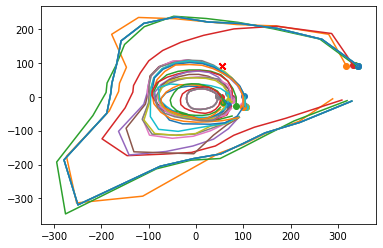

moved: (608.8427561426763, 607.471389103942)
Healing: moving to given mean (608.8427561426763, 607.471389103942)


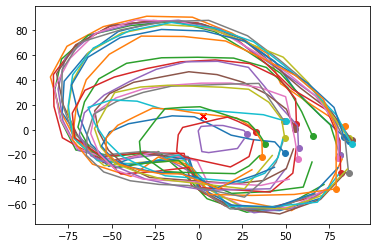

moved again: (608.8427561426763, 607.471389103942)
[[ 163.72972973 1003.10810811]
 [1074.54054054 1001.75675676]
 [1073.18918919   90.94594595]
 [ 165.08108108   90.94594595]]
[910.8118132964248, 910.8118132964248, 908.1081081081081] 0.4442922745281506
sf 0.4442922745281506
moved is: (608.8427561426763, 607.471389103942)
new_peaks: [54.15431416982369, 89.93583745855801] [2.2241383885736923, 11.288376521058012]


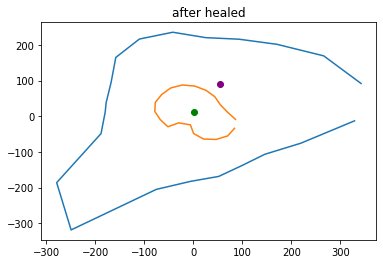

Moving to mean
levels skip: 3 [9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]
min/max level: 9 39
removing zeroes
levels skip: 3 [12, 15, 18, 21, 24, 27, 30, 33, 36]
min/max level: 12 36
removing zeroes
after export plot show [array([662.9970703125, 697.4072265625], dtype=object), array([611.06689453125, 618.759765625], dtype=object)]


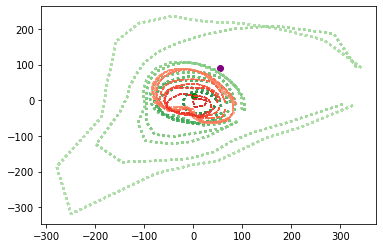

move_to_mean: (-4.4706344787609376e-14, -7.369561523582484e-14, 9) moved (608.8427561426763, 607.471389103942)
Moved was (608.8427561426763, 607.471389103942) to [2.2241383885736923 11.288376521058012]
Move_to_mean was (-4.4706344787609376e-14, -7.369561523582484e-14, 9) to [2.224138388573737 11.288376521058085]
Wrote meta (for AFM-C HUVEC 20200626 Group #1, Cell #2) to export_contours/test_HUVEC1_L4/file.txt


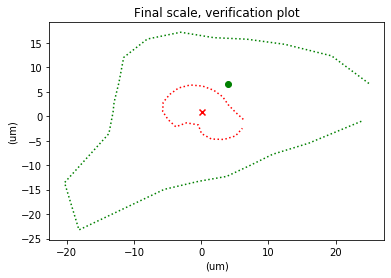

In [76]:
def make_contour(output_folder, annotation_folder, probe_info=None, npts=21, padding=20, mirror_x=0, mirror_y=0, cXY=None):

    tags = ['nucleus_linear3D', 'cyto_linear3D', 'other_linear3D']

    envelope_nucleus = contour.convert_annotated(annotation_folder, 'nucleus_linear3D')
    envelope_cyto = contour.convert_annotated(annotation_folder, 'cyto_linear3D')
    envelope_other = contour.convert_annotated(annotation_folder, 'other_linear3D')

    ee = deepcopy(envelope_cyto)
    ne = deepcopy(envelope_nucleus) if len(envelope_nucleus) else deepcopy(envelope_other)
    cyto_padded = contour.reparam_contour3(ee, ne, doPlot=False, padding=padding, npts=npts, debug=True, cXY=cXY)
    nuc_padded = contour.reparam_contour3(ne, None, doPlot=False, padding=padding, npts=npts, debug=True, cXY=cXY)

    ###################
    # Caps and overhang
    if False:
        for n in list(sorted(nuc_padded.keys())):
            if n not in envelope_cyto:
                cyto_padded[n] = deepcopy(nuc_padded[n])
                print('Adding cyto layer to match nuc', n)

    if False:
        min_ne = min(nuc_padded.keys())
        if min_ne - 1 not in cyto_padded:
            print('Adding bottom layer')
            cyto_padded[min_ne - 1] = deepcopy(nuc_padded[min_ne])

    cyto_padded = contour.reparam_contour3(cyto_padded, nuc_padded, doPlot=False, padding=padding, npts=npts)
    nuc_padded = contour.reparam_contour3(nuc_padded, None, doPlot=False, padding=padding, npts=npts)

    cap_size_top = 2
    cap_size_bot = 2
    if True:
        # build up cyto above last nucleus
        max_ne = max(nuc_padded.keys())
        while max_ne >= max(cyto_padded.keys())-cap_size_top:
            print('Adding top cap at: ', max(cyto_padded.keys())+1)
            cyto_padded[max(cyto_padded.keys())+1] = deepcopy(cyto_padded[max(cyto_padded.keys())])

        min_ne = min(nuc_padded.keys())
        print('min:', min_ne, min(cyto_padded.keys()))
        while min_ne <= min(cyto_padded.keys())+cap_size_bot:
            print('Adding bottom cap at: ', min(cyto_padded.keys())-1)
            cyto_padded[min(cyto_padded.keys())-1] = deepcopy(cyto_padded[min(cyto_padded.keys())])

    if False:
        max_ne = max(nuc_padded.keys())
        cap_size = 0.3
        if max_ne + 1 not in cyto_padded:
            print('Adding cap layer')
            cyto_padded[max_ne + 1] = deepcopy(cyto_padded[max_ne])
            if cap_size > 0:
                cyto_padded[max_ne + 1] = deepcopy(cyto_padded[max_ne])
            if cap_size > 0.1:
                cyto_padded[max_ne + 2] = deepcopy(cyto_padded[max_ne])
            if cap_size > 0.2:
                cyto_padded[max_ne + 3] = deepcopy(cyto_padded[max_ne])


        # maybe a while loop?
        cap_size = 0.3
        min_ne = min(cyto_padded.keys())
        if min_ne >= min(nuc_padded.keys()):
            print('Adding bottom cap layer')
            if cap_size > 0:
                cyto_padded[min_ne - 1] = deepcopy(cyto_padded[min_ne])
            if cap_size > 0.1:
                cyto_padded[min_ne - 2] = deepcopy(cyto_padded[min_ne])
            if cap_size > 0.2:
                cyto_padded[min_ne - 3] = deepcopy(cyto_padded[min_ne])

    #################
    # Countour Healing

    # Bad values, because they don't account for centering
    tp0 = contour.transform_probe(probe_info[0], mirror_x=mirror_x, mirror_y=mirror_y)
    tp1 = contour.transform_probe(probe_info[1], mirror_x=mirror_x, mirror_y=mirror_y)

    print('transformed:', tp0, tp1)
    cyto_contour, moved = confocal.heal_contour(cyto_padded, probe_marker=tp0)
    print('moved:', moved)
    # # print(res.keys())
    nucleus_contour, moved = confocal.heal_contour(nuc_padded, move_to_mean=moved, probe_marker=tp1)
    print('moved again:', moved)
    sf = contour.get_scaling_factor(open(os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/annotation', 'scaling.json')))

    # plot healed
    plt.plot(cyto_contour[min(cyto_contour.keys())][0],cyto_contour[min(cyto_contour.keys())][1])
    plt.plot(nucleus_contour[min(nucleus_contour.keys())][0],nucleus_contour[min(nucleus_contour.keys())][1])
    plt.title('after healed')

    print('moved is:', moved)
    new_peak0 = [(tp0[0]-moved[0])*(0.03237/sf)**0,  (tp0[1]-moved[1])*(0.03237/sf)**0]
    new_peak1 = [(tp1[0]-moved[0])*(0.03237/sf)**0,  (tp1[1]-moved[1])*(0.03237/sf)**0]

    print('new_peaks:', new_peak0, new_peak1)
    plt.scatter(new_peak0[0],new_peak0[1], marker='o', color='purple')
    plt.scatter(new_peak1[0],new_peak1[1], marker='o', color='green')


    plt.show()


    os.makedirs(output_folder, exist_ok=True)

    # Export
    cyto_meta = confocal.export_contours(cyto_contour, ncvar='NCY', filen='C_Cyto_Z', scaling=(0.03237/sf, 0.03237/sf, 0.1),
                export_dir=output_folder, color_range='green', move_to_mean=None, skip_z=3, linestyle='dotted')
    nuc_meta = confocal.export_contours(nucleus_contour, ncvar='NC', filen='C_Nuc_Z', scaling=(0.03237/sf, 0.03237/sf, 0.1),
                export_dir=output_folder, color_range='red', move_to_mean=cyto_meta['move_to_mean'], skip_z=3, linestyle='dashed', linewidth=1)
    print('after export plot show', [tp0, tp1])


    plt.scatter(new_peak0[0],new_peak0[1], marker='o', color='purple')
    plt.scatter(new_peak1[0],new_peak1[1], marker='o', color='green')

    plt.show()

    print('move_to_mean:', cyto_meta['move_to_mean'], 'moved', moved)
    contour.export_probes(probes=[tp0, tp1], export_dir=output_folder, moved=moved, move_to_mean=cyto_meta['move_to_mean'], scaling=0.03237/sf)

    # move_to_mean: x_out = (x - xm) * scaling[0]



    meta_fname = os.path.join(output_folder,'file.txt')
    confocal.export_contours_meta('AFM-C HUVEC 20200626 Group #1, Cell #2', meta_fname, cyto_meta, nuc_meta)

    # Verification image
    nuc_re = contour.load_exported(os.path.join(output_folder, 'C_Nuc_Z01.txt'))
    cyto_re = contour.load_exported(os.path.join(output_folder, 'C_Cyto_Z01.txt'))
    p_c = [float(_.strip()) for _ in
           open(os.path.join(output_folder, 'probe_cyto.txt')).readlines()]
    p_n = [float(_.strip()) for _ in
           open(os.path.join(output_folder, 'probe_nuclear.txt')).readlines()]

    plt.plot(cyto_re.T[0], cyto_re.T[1], color='green', linestyle=':')
    plt.scatter(p_c[0], p_c[1], marker='o', color='green')
    plt.plot(nuc_re.T[0], nuc_re.T[1], linestyle=':', color='red')
    plt.scatter(p_n[0], p_n[1], marker='x', color='red')
    plt.title('Final scale, verification plot')
    plt.xlabel('(um)')
    plt.ylabel('(um)')

    plt.savefig(os.path.join(output_folder,'probe_positions.png'))
    plt.show()

    return [nuc_re, cyto_re]
    
all_tips = np.load(os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/', 'centered_all.npy'), allow_pickle=True)
all_xy_mirror = [[None, 1, 0, 0, 0, 0, 0, 0], [None, 1, 0, 0, 0, 0, 0, 0]]


_ = 4

mirror_x = all_xy_mirror[0][_]
mirror_y = all_xy_mirror[1][_]

print('Starting to export %d' % _)

print('tips: ', [all_tips[0][_][:2], all_tips[1][_][:2]])
res = make_contour(output_folder="export_contours/test_HUVEC1_L%d" % _, # special 'L' here for longitudinal
     annotation_folder='datasets/SR_HUVEC1/HUVEC Cell %d/annotation' % _,
     probe_info=[all_tips[0][_][:2], all_tips[1][_][:2]],
     mirror_x=mirror_x,
     mirror_y=mirror_y,
     cXY=(620, 600)
     # nuc_option='nucleus' if _ != 7 else 'other',
)



100%|██████████| 25/25 [00:00<00:00, 1324.29it/s]


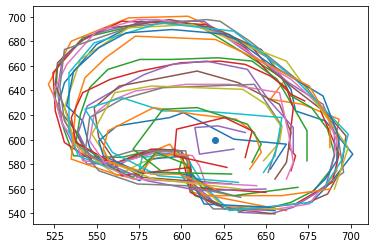

In [77]:
# To continue:
# 
envelope_nucleus = contour.convert_annotated('datasets/SR_HUVEC1/HUVEC Cell %d/annotation' % 4, 'nucleus_linear3D')

for _ in deepcopy(envelope_nucleus):
    plt.plot(envelope_nucleus[_][0],envelope_nucleus[_][1])
# plt.show()
    
plt.scatter([620],[600])

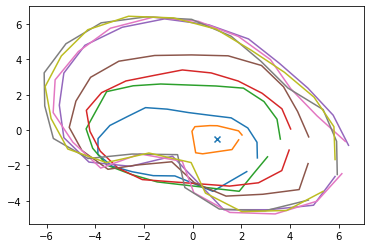

In [182]:
globbed = glob.glob(os.path.join("export_contours/test_HUVEC1_L%d" % 4, 'C_N*_Z*.txt'))
global_data = []
for fname in globbed:
    data = contour.load_exported(fname)
    plt.plot(data.T[0], data.T[1])
    global_data.append(data)
    
plt.scatter(1,-0.5,marker='x')

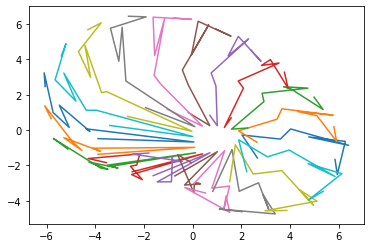

In [79]:
gt = np.array(global_data).T
gt.shape
for _ in range(20):
    plt.plot(gt[0][_],gt[1][_])

# Principled retry

100%|██████████| 25/25 [00:00<00:00, 1779.87it/s]

[[662.08108108 606.67567568 602.62162162 593.16216216 574.24324324
  556.67567568 541.81081081 532.35135135 521.54054054 535.05405405
  568.83783784 603.97297297 628.2972973  652.62162162 660.72972973
  652.62162162 671.54054054 693.16216216 691.81081081 691.81081081
  683.7027027 ]
 [542.2972973  557.16216216 580.13513514 596.35135135 585.54054054
  578.78378378 589.59459459 612.56756757 645.         680.13513514
  699.05405405 700.40540541 685.54054054 665.27027027 647.7027027
  632.83783784 628.78378378 616.62162162 605.81081081 574.72972973
  559.86486486]]
dict_keys([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])


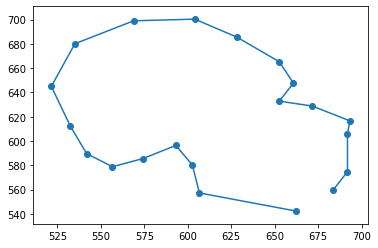

In [95]:
exc = contour.convert_annotated('datasets/SR_HUVEC1/HUVEC Cell %d/annotation' % 4, 'nucleus_linear3D')
target_level = 13
print(exc[target_level])
plt.plot(exc[target_level][0],exc[target_level][1])
plt.scatter(exc[target_level][0],exc[target_level][1])
print(exc.keys())

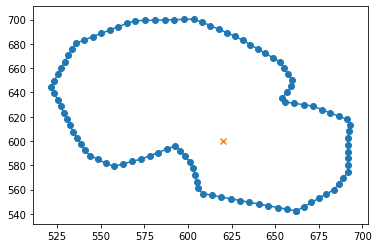

In [100]:
# lightly modified to run, from contour.py, edit_level fxn
def make_more_pts_dist(contour, heal=False, npts=101):

    # Get points from this level
    lx = contour[0]
    ly = contour[1]

    if heal:
        #             print('healing!', lx)
        lx = np.hstack([lx, [lx[0], ]])
        ly = np.hstack([ly, [ly[0], ]])

        # Accumulate distance along the contour described, so that we can interpolate along it
    dist = np.array(
        [0, ] + [np.sqrt((i1 - i0) ** 2 + (j1 - j0) ** 2) for i0, i1, j0, j1 in zip(lx[1:], lx, ly[1:], ly)])
    sumdist = np.array(list(itertools.accumulate(dist)))

    # Interpolation of x, y after distance sumdist along the curve
    fx = interp1d(sumdist, lx)
    fy = interp1d(sumdist, ly)

    # Interpolate 101 pieces
    gd = np.linspace(0, sumdist[-1], npts)
    gx_, gy_ = fx(gd), fy(gd)

    return gx_, gy_

exc_morepts = make_more_pts_dist(exc[target_level], heal=True)

# print(exc_morepts)
plt.plot(exc_morepts[0], exc_morepts[1])
plt.scatter(exc_morepts[0], exc_morepts[1])
plt.scatter(620, 600, marker='x')

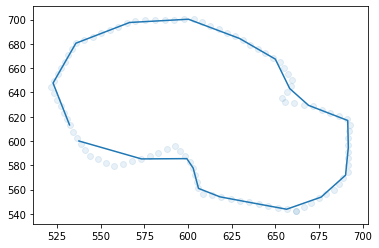

In [115]:
def get_radius_theta(x, y, cX, cY):
    dX = x - cX
    dY = y - cY

    radius = np.sqrt(dX ** 2 + dY ** 2)
    theta = np.arctan2(dY, dX)
    #         print('theta:', theta)

    #         ftx_ = interp1d(theta, dX)
    #         fty_ = interp1d(theta, dY)

    st, sr = zip(*sorted(zip(theta, radius)))

    #         print('theta interp:', st, sr)

    ftr = interp1d(st, sr, bounds_error=False, fill_value=(sr[0] + sr[-1]) / 2)

    #         print('funciont theta:', st)

    return radius, theta, ftr

cXg = 620
cYg = 600
exc_rad, exc_the, exc_ftr = get_radius_theta(exc_morepts[0], exc_morepts[1], cXg, cYg)
npts = 21
t0 = np.linspace(-np.pi, np.pi - np.pi / npts, npts)
r0g = exc_ftr(t0)
gx, gy = cXg + r0g * np.cos(t0), cYg + r0g * np.sin(t0)

plt.plot(gx, gy)
plt.scatter(exc_morepts[0], exc_morepts[1], alpha=0.1)

Files: 11 9
(20,) (3, 20)
(20,) (3, 20)
(20,) (3, 20)
(20,) (3, 20)
(20,) (3, 20)
(20,) (3, 20)
(20,) (3, 20)
(20,) (3, 20)
(20,) (3, 20)
(9, 3, 20)


/Users/asears/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/asears/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


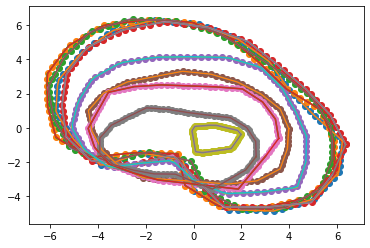

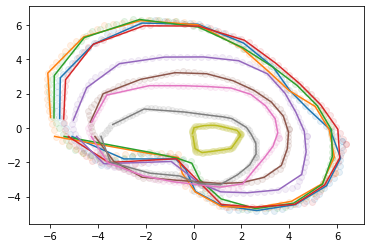

(3, 20)
(3, 20)
(3, 20)
(3, 20)
(3, 20)
(3, 20)
(3, 20)
(3, 20)
(3, 20)


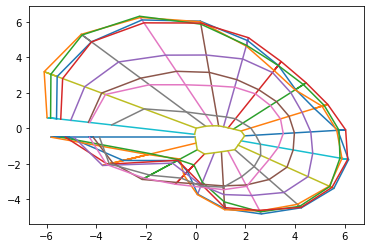

In [192]:
# Config
cXg, cYg = 620, 600 # Concentric point for describing contours radially
npts_extra = 101
cell_num = 4

# Input files
input_folder = "export_contours/test_HUVEC1_%d" % cell_num
output_folder = "export_contours/test_HUVEC1_L%d" % cell_num
input_cyto = glob.glob(os.path.join(input_folder, 'C_Cyto_Z*.txt'))
input_nuc = glob.glob(os.path.join(input_folder, 'C_Nuc_Z*.txt'))

print('Files:', len(input_cyto), len(input_nuc))

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

all_edits = []

os.makedirs(output_folder,exist_ok=True)
# Load contours and output one by one
for fname in sorted(input_nuc):
    nuc_re = contour.load_exported_ext(fname)
    rows = np.array(nuc_re['rows']).T
#     print(rows.shape)
    ax1.plot(rows[0], rows[1])
    # the only deficiency in this approach is that we don't have

    exc_morepts = make_more_pts_dist(rows, heal=True)

    # print(exc_morepts)
    ax1.plot(exc_morepts[0], exc_morepts[1])
    ax1.scatter(exc_morepts[0], exc_morepts[1])
#     ax1.scatter(cXg,cYg, marker='x')
    
    cXg = 1
    cYg = -0.5

    
    exc_rad, exc_the, exc_ftr = get_radius_theta(exc_morepts[0], exc_morepts[1], cXg, cYg)
    npts = rows.shape[1]
    t0 = np.linspace(-np.pi, np.pi - np.pi / npts, npts)
    r0g = exc_ftr(t0)
    gx, gy = cXg + r0g * np.cos(t0), cYg + r0g * np.sin(t0)

    ax2.plot(gx, gy)
    ax2.scatter(exc_morepts[0], exc_morepts[1], alpha=0.1)
    
    altered_contour = np.array([gx, gy, rows[-1][:]])
    print(np.shape(gx), np.shape(rows))
    all_edits.append(altered_contour)
    
all_edits = np.array(all_edits)

print(np.shape(all_edits))
fig1.show()
fig2.show()
plt.show()
for _ in all_edits.transpose([2,0,1]):
#     print(_.shape)
    plt.plot(_[:,0], _[:,1])
    
for _ in all_edits.transpose([0,1,2]):
    print(_.shape)
    plt.plot(_[0],_[1])
        

Files: 11
Re-centering 1 -0.5


/Users/asears/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/asears/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


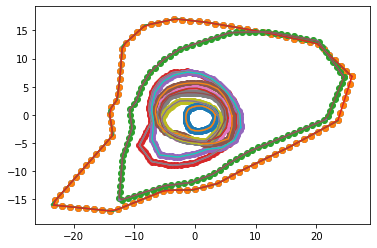

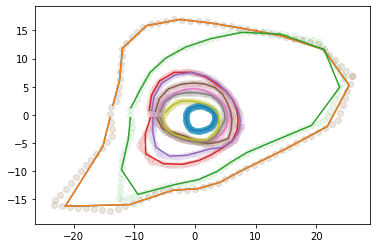

Files: 9
Re-centering 1 -0.5


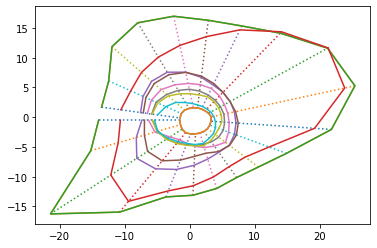

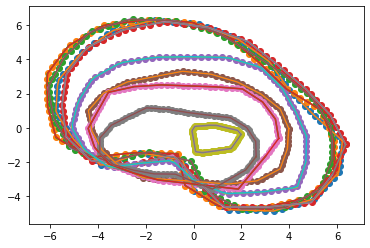

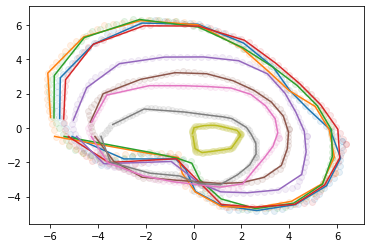

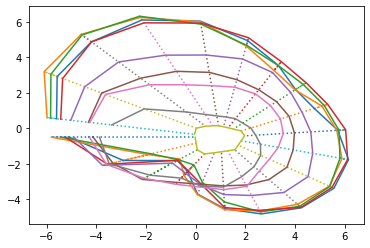

In [223]:
def remake_contours(input_folder, file_stub, recentering=None, adjust_probe=False, title=''):
    input_contours = glob.glob(os.path.join(input_folder, file_stub))

    print('Files:', len(input_contours))
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    all_edits = []
    if recentering is not None:
        cXg, cYg = recentering
    else:
        cXg, cYg = 0,0
        
    print('Re-centering', cXg, cYg)

    # Load contours and output one by one
    for fname in sorted(input_contours):
        nuc_re = contour.load_exported_ext(fname)
        rows = np.array(nuc_re['rows']).T
        
        if adjust_probe:
            
            rows[0] -= cXg
            rows[1] -= cYg
            zcXg = 0
            zcYg = 0
        else:
            zcXg = cXg
            zcYg = cYg
#         rows -= np.array([cXg, cYg, 0])
        
    #     print(rows.shape)
        ax1.plot(rows[0], rows[1])
        # the only deficiency in this approach is that we don't have

        exc_morepts = make_more_pts_dist(rows, heal=True)

        # print(exc_morepts)
        ax1.plot(exc_morepts[0], exc_morepts[1])
        ax1.scatter(exc_morepts[0], exc_morepts[1])
    #     ax1.scatter(cXg,cYg, marker='x')



        exc_rad, exc_the, exc_ftr = get_radius_theta(exc_morepts[0], exc_morepts[1], zcXg, zcYg)
        npts = rows.shape[1]
        t0 = np.linspace(-np.pi, np.pi - np.pi / npts, npts)
        r0g = exc_ftr(t0)
        gx, gy = zcXg + r0g * np.cos(t0), zcYg + r0g * np.sin(t0)

        ax2.plot(gx, gy)
        ax2.scatter(exc_morepts[0], exc_morepts[1], alpha=0.1)

        altered_contour = np.array([gx, gy, rows[-1][:]])
#         print(np.shape(gx), np.shape(rows))
        all_edits.append(altered_contour)

    all_edits = np.array(all_edits)

#     print(np.shape(all_edits))
    fig1.show()
    fig2.show()
    plt.show()
    for _ in all_edits.transpose([2,0,1]):
    #     print(_.shape)
        plt.plot(_[:,0], _[:,1], linestyle=':')
    

    for _ in all_edits.transpose([0,1,2]):
#         print(_.shape)
        plt.plot(_[0],_[1])
    plt.savefig(os.path.join(output_folder,'%s.png' % title),bbox_inches='tight')
    pass

    return all_edits

remade_cyto = remake_contours(input_folder=input_folder, file_stub='C_Cyto_Z*.txt', recentering = (1,-0.5), adjust_probe=False, title='Cyto')
remade_nuc = remake_contours(input_folder=input_folder, file_stub='C_Nuc_Z*.txt', recentering = (1,-0.5), adjust_probe=False, title='Nuc')

#     input_nuc = glob.glob(os.path.join(input_folder, 'C_Nuc_Z*.txt'))

# remade_nuc = remake_contours()


In [221]:
def rewrite(nuc_contours, cyto_contours, output_folder, offset, zs=None, levels=None):
    os.makedirs(output_folder,exist_ok=True)
    for n,row in enumerate(nuc_contours):
        fname_out = os.path.join(output_folder, 'C_Nuc_Z%02d.txt' % (n+1))
        print(fname_out)
        print(row)
        
        with open(fname_out,'w') as fout:
            fout.write('!-----------------------\n')
            fout.write('!Contour #%02d' % (n) + '\n')
            fout.write('!-----------------------\n')
            fout.write('NC(%d)=%d\n' % (n, len(row[0])))

            for r in row.T:
                fout.write('k,,%0.3f,%0.3f,%0.3f\n' % (r[0], r[1], r[2]))
            
        
    for n,row in enumerate(cyto_contours):
        fname_out = os.path.join(output_folder, 'C_Cyto_Z%02d.txt' % (n+1))
        print(fname_out)
        print(row)
    
        with open(fname_out,'w') as fout:
            fout.write('!-----------------------\n')
            fout.write('!Contour #%02d' % (n) + '\n')
            fout.write('!-----------------------\n')
            fout.write('NC(%d)=%d\n' % (n, len(row[0])))

            for r in row.T:
                fout.write('k,,%0.3f,%0.3f,%0.3f\n' % (r[0], r[1], r[2]))
        
rewrite(remade_nuc, remade_cyto, output_folder="export_contours/test_HUVEC1_L%d" % cell_num, offset=None, zs=None, levels=None)


export_contours/test_HUVEC1_L4/C_Nuc_Z01.txt
[[-5.08666284 -2.91709697 -0.74548186 -0.3278745   0.0744874   1.16659993
   2.64451834  4.25345388  5.563445    6.15217388  5.7201459   4.77667934
   4.02021246  3.32369475  2.09403169  0.18459725 -2.16368513 -4.2003094
  -5.58007211 -5.60546437]
 [-0.5        -1.80864209 -1.8128028  -2.42637763 -3.70540846 -4.52801484
  -4.81965988 -4.47270973 -3.37492569 -1.75947496 -0.10887756  1.1195082
   2.1894185   3.55049468  4.94126888  6.04154515  6.10935143  4.87518799
   2.92152845  0.54620278]
 [ 0.3         0.3         0.3         0.3         0.3         0.3
   0.3         0.3         0.3         0.3         0.3         0.3
   0.3         0.3         0.3         0.3         0.3         0.3
   0.3         0.3       ]]
export_contours/test_HUVEC1_L4/C_Nuc_Z02.txt
[[-5.81245797 -1.91900703 -0.63138006 -0.47656766  0.06697905  1.16885944
   2.58212343  4.09557669  5.37787708  5.8877715   5.67881826  5.085389
   3.9995069   3.15683455  2.03300123  